<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Векторизация текстов" data-toc-modified-id="Векторизация текстов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Векторизация текстов</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>

# Проект для интернет-магазина c нейросетью BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Задача: обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок. 

Требование к результату: модель со значением метрики качества *F1* не меньше 0.75. Для выполнения проекта применять *BERT*.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загружаем необходимые библиотеки.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import torch
import transformers
from tqdm import notebook
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (accuracy_score, recall_score, 
                             precision_score, f1_score, confusion_matrix, 
                             ConfusionMatrixDisplay, RocCurveDisplay,
                             roc_auc_score, roc_curve, auc,
                             precision_recall_curve, fbeta_score)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

import optuna
from optuna.samplers import TPESampler

RANDOM_STATE = 42

Загружаем исходный датасет с облака. В качестве индексов выбирает 0 столбец.

In [3]:
df_tweets = pd.read_csv('...', index_col=[0])
df_tweets.reset_index(drop=True, inplace=True)

Получим информацию о датасете.

In [4]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Выведем случайные 20 строк, чтобы посмотреть с какими данными будем работать.

In [5]:
df_tweets.sample(20)

,text,toxic
76428,", it is understandable",0
150411,Anatomy Picture\nThe woman in this picture as ...,0
71032,"""\n\nFurther since there are so many Arabs in ...",0
80989,Actually consensus was no consensus and so I m...,0
148413,"""\n\n File:JohnServo.jpg listed for deletion \...",0
102467,Radio Series \nDon't know if its worth adding ...,0
67832,About Wikipedia:Articles for deletion/Jurong E...,0
65785,"I've fixed the problem, see User:Lunchboxhero/...",0
69241,That is completely irrelevant. The fact is tha...,0
146007,MATE JUST GO SCREW YOURSELF OK. If you want to...,1


В текстах кроме букв и слов имеются символы, ошибки в написании слов, сокращения слов. Данные ошибки необходимо исправлять. 

Перед разметкой датасета необходимо:
- Удалить стоп-слов;
- Леммантизировать текст;
- Очистить от символов.

Так как в проекте будет использована нейросеть BERT, разработки компании Google, то необходимость в леммантизации текстов отпадает, так как эта нейросеть отлично работает с "сырым" текстом.

## Векторизация текстов

Выполнение задачи получения embeddings требует большого количества вычислительных процессов. Для ускорения используют вычисления на GPU.

Для работы с GPU проверим, корректно ли подключено устройство.

In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
print(torch.cuda.get_device_name()) 

cuda:0
NVIDIA GeForce GTX 1650


Устройство подключено корректно, можно приступать к преобразованию текстов.

In [7]:
print(df_tweets['text'].str.len().max())

5000


В датасете некоторые тексты достигают длину около 5 000 символов. При этом нейросеть BERT работает с максимальной длиной 512 символов. Поэтому используем аргумент truncation=True в токенизаторе, который обрежет текст до максимального количества символов.

Инициализируем токенизатор как объект класса BertTokenizer(). Передадим ему аргумент vocab_file предварительно скачанный с hugging face.

Преобразуем текст в номера токенов из словаря методом encode() с добавоением спец токенов. К данным текстам применим функцию обрезки по количеству символов.

Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными. Только при таком условии будет работать модель BERT. Пусть стандартной длиной вектора n будет длина наибольшего во всём датасете вектора. Остальные векторы дополним нулями.

Теперь поясним модели, что нули не несут значимой информации. Это нужно для компоненты модели, которая называется attention_mask. Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения.

In [9]:
#Загружаем предобученный токенизатор BERT
model_path = 'JungleLee/bert-toxic-comment-classification'
tokenizer = transformers.BertTokenizer.from_pretrained(model_path)

#Трансформируем текст моделью BERT с усечением текста
tokenized = df_tweets['text'].progress_apply(
            lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

#Выбираем максимальную длину текста
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

# Для текстов длиной меньше max_len применяет отступы        
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# Создаем маску attention
attention_mask = np.where(padded != 0, 1, 0)

Инициализируем конфигурацию BertConfig. В качестве аргумента передадим ей JSON-файл с описанием настроек модели предварительно скаченного с hugging face. 

Затем инициализируем саму модель класса BertModel. Передадим ей файл с предобученной моделью и конфигурацией. Можно было вместо указания локального файла использовать код аналогично токенизатору, но постоянно загружать по 500 МБ файлов не вариант.

In [10]:
# Загружаем модель BERT
model = transformers.BertModel.from_pretrained(model_path)

Embeddings модель BERT создаёт батчами. Чтобы хватило памяти видеокарты, сделаем размер батча небольшим - равным 100.

Сделаем цикл по батчам. Отображать прогресс будет функция notebook(), таким образом мы сможем в реальном времени видеть сколько тратится времени на каждый батч, прогресс и сколько осталось времени до конца работы цикла. 

Преобразуем данные в формат тензоров в библиотеке torch. Тип данных LongTensor хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита. Чтобы получить эмбеддинги для батча, передадим модели данные и маску.

Для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.

Из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов.

Весь цикл выполняется с помощью GPU, поэтому батчи, маску и модель необходимо загрузить в GPU. А после добавлять embeddings на CPU.

In [11]:
#Код закомменчен, так как выполняется в течении 13 часов и результат сохранен в локальном файле

batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            model.to(device)
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

Соберём все эмбеддинги в матрицу признаков вызовом функции concatenate():

In [12]:
features = np.concatenate(embeddings)

Далее сохраним полученные embeddings и attention_mask в файл. Таким образом при перезагрузке тетради, данные не потеряются.

In [13]:
np.save('features', features)
np.save('attention_mask', attention_mask)

## Подготовка признаков для классификации

Загружаем признаки из файл, который получили в предыдущем разделе.

In [14]:
# Загружаем предварительно полученные embeddings
features = pd.DataFrame(np.load('features2.npy'))

Делим данные на тренировочный и тестовый датасеты в соотношении 9:1. В процессе создания embeddings получены признаки для 159 200 текстов, поэтому в качестве целевого признака возьмем аналогичное количество строк. Потеря 92 признаков не повлияет на качество предсказание модели классификации. 

In [15]:
(train_features, test_features, 
 train_target, test_target) = train_test_split(features, df_tweets['toxic'][:159200], 
                                               test_size=0.1, random_state=RANDOM_STATE,
                                               stratify=df_tweets['toxic'][:159200])

Проверяем соотношение классов в тренировочной выборке.

In [16]:
train_target.value_counts()

0    128718
1     14562
Name: toxic, dtype: int64

In [17]:
test_target.value_counts()

0    14302
1     1618
Name: toxic, dtype: int64

## Борьба с дисбалансом классов

Так как нам важно предсказать токсичные твиты, а количество твитов с классом 1 почти в 9 раз меньше класса 0, необходимо применить методы борьбы с дисбалансом. В данном проекте применим следующие методы:
- upsampling - повторение несколько раз редкого класса. В нашем случае повторение класса "токсичных" твитов. Алгоритм преобразования upsampling выглядит следующим образом: деление выборки на отрицательные и положительные объекты, скопирование несколько раз положительных объектов, с учетом полученных данных создание новой выборки, перемешивание данных;
- downsampling - уменьшение в выборке частого класса. Алгоритм преобразования downsampling похож на upsampling и выглядит следующим образом: деление выборки на отрицательные и положительные объекты, случайным образом отбросить часть отрицательных значений, с учетом полученных данных создание новой выборки, перемешивание данных.

### Upsampling

Upsampling - увеличение в n раз наименьшего класса. Преобразование проходит в несколько этапов:
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Скопировать несколько раз положительные объекты;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные.

Напишем функцию выполняющую данное преобразование.

In [18]:
# Создаем функцию преобразования Upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]       # Выбираем признаки с целевым значением 0
    features_ones = features[target == 1]        # Выбираем признаки с целевым значением 0
    target_zeros = target[target == 0]           # Выбираем целевой признак равный 0
    target_ones = target[target == 1]            # Выбираем целевой признак равный 0

    # Соединяем оба класса с учетом копирования наименьшего repeat раз
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # Перемешиваем данные
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    # Возвращаем перемешанные данные на выход
    return features_upsampled, target_upsampled

Оценку результатов применения методов борьбы с дисбалансом проведем на тестовой модели после подбора оптимальных гиперпараметров.

### Downsampling

Downsampling - удаление части наибольшего класса. Преобразование проходит в несколько этапов:
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросить часть из отрицательных объектов;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

Напишем функцию выполняющую данное преобразование.

In [19]:
# Создаем функцию преобразования downsampling
def downsample(features, target, fraction):
    features_zeros = features[target == 0]       # Выбираем признаки с целевым значением 0
    features_ones = features[target == 1]        # Выбираем признаки с целевым значением 0
    target_zeros = target[target == 0]           # Выбираем целевой признак равный 0
    target_ones = target[target == 1]            # Выбираем целевой признак равный 0

    # Соединяем оба класса с учетом уменьшения наибольшего класса
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    # Перемешиваем данные
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)
    # Возвращаем перемешанные данные на выход
    return features_downsampled, target_downsampled

Оценку результатов применения методов борьбы с дисбалансом проведем на тестовой модели после подбора оптимальных гиперпараметров.

## Подбор гиперпараметров модели

С целью улучшения результатов моделей необходимо провести подбор оптимальных гиперпараметров. Для этого есть несколько решений.

**Grid Search** 

Самый естественный способ организовать перебор наборов гиперпараметров — сделать перебор по сетке:
- для каждого гиперпараметра фиксируется несколько значений;
- перебираются все комбинации значений различных гиперпараметров, на каждой из этих комбинаций модель обучается и тестируется;
- выбирается комбинация, на которой модель показывает лучшее значение метрики.

Большой минус данного метода: если комбинаций параметров слишком много, либо каждое обучение длится долго, алгоритм не завершится за разумное время.

**Random Search**

Если количество комбинаций параметров очень большое, можно какими-то способами пытаться справляться с этой проблемой:

- взять меньше значений каждого гиперпараметра, но тогда есть шансы пропустить наилучшую комбинацию;
- уменьшить число фолдов в кросс-валидации, но оценка параметров станет более шумной;
- оптимизировать параметры последовательно, а не перебирать их комбинации, но снова есть шанс получить неоптимальное решение;
- перебирать не все комбинации гиперпараметров, а только случайное подмножество.

Последний способ называется Random Search. Для каждого гиперпараметра задаётся распределение, из которого выбирается его значение, и комбинация гиперпараметров составляется семплированием из этих распределений. Таким образом, благодаря случайному выбору очередной комбинации гиперпараметров можно найти оптимальную комбинацию за меньшее число итераций.

**Optuna**

Другим методом подбора гиперпараметров является библиотека Optuna. **Optuna** — это фреймворк для для автоматизированного поиска оптимальных гиперпараметров для моделей машинного обучения. Она подбирает эти параметры методом проб и ошибок.

Ключевые особенности фреймворка:
- настраиваемое пространство поиска гиперпараметров. Разработчик может самостоятельно задать пространство для поиска гиперпараметров, используя базовый синтаксис Python (циклы, условия);
- алгоритмы SoTA для выбора гиперпараметров из пространства заданного разработчиком (samplers) и для ранней остановки бесперспективных экспериментов (pruners). В Optuna представлены различные алгоритмы семплирования и прунинга, разработчик может выбрать какой-то конкретный, оставить дефолтный, или написать свой собственный;
- легкость расспаралеливания процесса поиска гиперпараметров. Также к Optuna можно прикрутить dashboard с визуализацией обучения в реальном времени.

Так же в Optunа можно добавить pipline и кросс-валидацию.

Напишем фукнцию для перебора гиперпараметров. В функции имеется несколько моделей, но по скорости предсказания LGBM показывает лучший результат. Поэтому проведем подбор только с данной моделью. ~В качестве борьбы с дисбалансом используем метод downsample, так как он выдал результат немного лучше.~

In [20]:
def objective(trial: optuna.Trial):
    
    
    model_type = trial.suggest_categorical("model_type", [#"XGBoost", 
                                                          #"CatBoost", 
                                                          "LightGBM",
                                                          #"Tree",
                                                          #"RandomForest"
                                                            ])
    
    if model_type == "XGBoost":
        xgboost_params = {
            'tree_method':'gpu_hist',  
            'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.02, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 20),
        }
        
        model = XGBClassifier(**xgboost_params, n_jobs=-1, random_state=RANDOM_STATE)
        
    
    elif model_type == "CatBoost":
        catboost_params = {
            'iterations':trial.suggest_int("iterations", 1000, 1500),
            'od_wait':trial.suggest_int('od_wait', 100, 500),
            'learning_rate' : trial.suggest_float('learning_rate',0.01, 0.1, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda',1e-5,100),
            'depth': trial.suggest_int('depth',5, 16),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 30),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        }

        model = CatBoostClassifier(**catboost_params, silent=True, #task_type="GPU", 
                                   random_state=RANDOM_STATE)

    
    elif model_type == "LightGBM":
        lgbm_params = {
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.1, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 20),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
            'lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0)         
        }
        
        model = LGBMClassifier(verbose=-1, **lgbm_params, n_jobs=-1, 
                               random_state=RANDOM_STATE, device='gpu')
        
        
    elif model_type == "Tree":
        tree_params = {
            'max_depth': trial.suggest_int('max_depth',5, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20)
            }

        model = DecisionTreeClassifier(**tree_params, random_state=RANDOM_STATE)

    
    elif model_type == "RandomForest":
        forest_params = {
            'n_estimators':trial.suggest_int("n_estimators", 1000, 2500),
            'max_depth': trial.suggest_int('max_depth',5, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20)
        }

        model = RandomForestClassifier(**forest_params, n_jobs=-1, 
                                       random_state=RANDOM_STATE)

       
    pipe = Pipeline(steps=[
        
        ("model", model)
    ])
    cv = KFold(n_splits=3)
    
    score = cross_val_score(estimator=pipe,
                            X=train_features,
                            y=train_target,
                            scoring='f1',
                            cv=cv)
    
    trial.set_user_attr("model", pipe)
    trial.set_user_attr("cross_val_score", score)
    
    f1_score = score.mean()
    
    return f1_score

Напишем функцию для вывода значений метрик при кросс-валидации.

In [21]:
# Определение Callback для вывода метрик
def custom_callback(study: optuna.Study, trial: optuna.Trial):
    trial.user_attrs["cross_val_score"]
    score = trial.user_attrs["cross_val_score"]
    print(f"Trial {trial.number}: cross_val_score={score}")

Samplers в Optuna это набор алгоритмов для поиска гиперпараметров. Зададим поиск гиперпараметров с максимизацией метрики, sampler - TPESampler, pruner - HyperbandPruner. 

Samplers в Optuna это набор алгоритмов для поиска гиперпараметров. 

Pruners в Optuna - это набор алгоритмов для прореживания экспериментов. Pruning - это механизм который позволяет обрывать эксперименты , которые с большой долей вероятности приведут к не оптимальным результатам.

Так как каждая попытка предсказания занимает 3-5 минут, укажем малое количество попыток. На момент подготовки проекта количество попыток равнялось 50, среди них выбран лучший результат. 

In [22]:
study = optuna.create_study(direction="maximize", 
                            sampler = TPESampler(seed=RANDOM_STATE),
                            pruner = optuna.pruners.HyperbandPruner(),
                            study_name=f"Pipeline_training_example_{dt.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
study.optimize(objective, n_trials=5, callbacks=[custom_callback])

[I 2024-02-04 19:44:23,699] A new study created in memory with name: Pipeline_training_example_2024-02-04_19-44-23
[I 2024-02-04 19:47:16,103] Trial 0 finished with value: 0.8830778136194258 and parameters: {'model_type': 'LightGBM', 'max_depth': 10, 'learning_rate': 0.08829539000587418, 'n_estimators': 1491, 'min_child_weight': 11.973571025456534, 'min_child_samples': 39, 'reg_lambda': 0.15683852581586644}. Best is trial 0 with value: 0.8830778136194258.


Trial 0: cross_val_score=[0.89001657 0.88307474 0.87614213]


[I 2024-02-04 19:49:07,680] Trial 1 finished with value: 0.8829492736720796 and parameters: {'model_type': 'LightGBM', 'max_depth': 5, 'learning_rate': 0.07131933323851132, 'n_estimators': 1242, 'min_child_weight': 14.161743483343113, 'min_child_samples': 13, 'reg_lambda': 0.9699399423098324}. Best is trial 0 with value: 0.8830778136194258.


Trial 1: cross_val_score=[0.89015544 0.8831961  0.87549628]


[I 2024-02-04 19:50:42,313] Trial 2 finished with value: 0.8859773068341174 and parameters: {'model_type': 'LightGBM', 'max_depth': 18, 'learning_rate': 0.013677505045234777, 'n_estimators': 445, 'min_child_weight': 3.6689067925588223, 'min_child_samples': 68, 'reg_lambda': 0.5252316752006057}. Best is trial 2 with value: 0.8859773068341174.


Trial 2: cross_val_score=[0.89241877 0.88548078 0.88003237]


[I 2024-02-04 19:54:28,707] Trial 3 finished with value: 0.8855879681320715 and parameters: {'model_type': 'LightGBM', 'max_depth': 11, 'learning_rate': 0.016693298027163676, 'n_estimators': 1263, 'min_child_weight': 2.7907377191801843, 'min_child_samples': 65, 'reg_lambda': 0.366995481450398}. Best is trial 2 with value: 0.8859773068341174.


Trial 3: cross_val_score=[0.89185553 0.88528906 0.87961932]


[I 2024-02-04 19:56:02,306] Trial 4 finished with value: 0.8818628106925334 and parameters: {'model_type': 'LightGBM', 'max_depth': 12, 'learning_rate': 0.0581242498601517, 'n_estimators': 479, 'min_child_weight': 10.285174533833818, 'min_child_samples': 123, 'reg_lambda': 0.047403962307277725}. Best is trial 2 with value: 0.8859773068341174.


Trial 4: cross_val_score=[0.88863589 0.88207929 0.87487325]


In [23]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)

Best params:  {'model_type': 'LightGBM', 'max_depth': 18, 'learning_rate': 0.013677505045234777, 'n_estimators': 445, 'min_child_weight': 3.6689067925588223, 'min_child_samples': 68, 'reg_lambda': 0.5252316752006057}
Best value:  0.8859773068341174


На 50 испытаниях получены следующие результаты:

**Best params:**  {'model_type': 'LightGBM', 'max_depth': 12, 'learning_rate': 0.01102363250153261, 'n_estimators': 702, 'min_child_weight': 4.090774497250733, 'min_child_samples': 184, 'reg_lambda': 0.7605630867585721}

**Best value:**  0.8867732427172056

Результат предсказаний можно сохранить на локальном компьютере для последующего использования.

In [24]:
#import joblib

#joblib.dump(study, 'experiments.pkl')

## Тестирование модели

Для тестирования выбраны гиперпараметры модели с лучшим результатом на тренировочном датасете. Использована модель, подобранная на 50 испытаниях.

In [25]:
# Создаем модель с оптимальными гиперпараметрами
best_model = LGBMClassifier(verbose=-1, random_state=RANDOM_STATE, max_depth=12,
                            learning_rate=0.01102363250153261, n_estimators=702, 
                            min_child_weight=4.090774497250733, min_child_samples=184, 
                            reg_lambda=0.7605630867585721, device='gpu')

best_model.fit(train_features, train_target)  # Обучаем модель
prediction = best_model.predict(test_features)    # Предсказываем данные моделью
result_f1 = f1_score(test_target, prediction) # Считаем f1-меру предсказаний модели
recall = recall_score(test_target, prediction)        # Считаем recall предсказаний модели
probabilities = best_model.predict_proba(test_features)[:,1] # Вероятность для ROC-AUC
roc = roc_auc_score(test_target, probabilities) # Считаем метрику ROC-AUC модели

print(f'Метрика Recall: {recall},')
print(f'Метрика F1 модели: {result_f1},')
print(f'Метрика ROC-AUC: {roc}.')

Метрика Recall: 0.9004944375772559,
Метрика F1 модели: 0.8889566809029896,
Метрика ROC-AUC: 0.9948924480727324.


Получаем метрику F1 равную **0.89**, что выше требуемого по заданию заказчика. Метрика Recall (доля правильных ответов положительного класса к общему количеству ответов положительного класса) равна **0.90**, что говорит о качественном предсказании положительного класса - токсичных твитах. Метрика ROC-AUC (площадь под кривой правильных ответов) равную **0.99**, но метрики Recall и ROC-AUC неправильно трактуются при имеющемся дисбалансе классов. Поэтому необходимо принять меры по борьбе с дисбалансом. За счет этого имеется возможность улучшить предсказание модели, в том числе, по целевой метрике F1.

## Применение методов борьбы с дисбалансом классов

Используем ранее написанную функцию для метода upsampling.

In [26]:
%%time

n_value = []
f1_result = []
for n in range(1, 12):
    features_upsampled, target_upsampled = upsample(train_features, train_target, n)
    best_model.fit(features_upsampled, target_upsampled)
    pred = best_model.predict(test_features)
    n_value.append(n)
    f1_result.append(f1_score(pred, test_target))

Wall time: 13min 11s


Лучшее значение метрики: 0.8889566809029896
Для n равном: 1


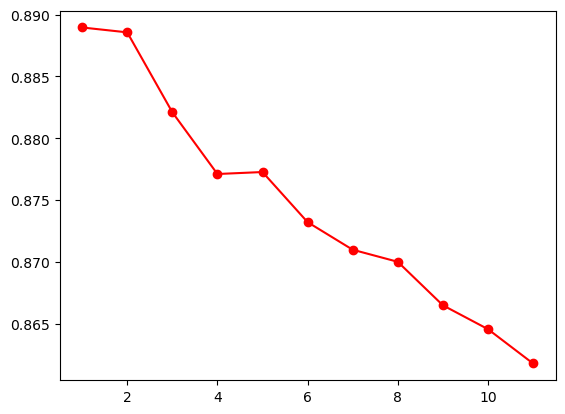

In [27]:
plt.plot(n_value, f1_result, 'ro-')
print(f'Лучшее значение метрики: {max(f1_result)}')
print(f'Для n равном: {n_value[f1_result.index(max(f1_result))]}')

Из графика видно, что лучшее значение метрики получается при n равном 1. Это значит, что upsampling не дает прирост в целевой метрике. На графике видна зависимость между n и целевой метрикой. При увеличении параметра n, метрика F1 снижается.

Аналогично используем ранее написанную функцию для метода downsampling.

In [28]:
%%time

frac_value = []
f1_result = []
for frac in range(1, 10):
    features_downsampled, target_downsampled = downsample(train_features, train_target, frac/10)
    best_model.fit(features_downsampled, target_downsampled)
    pred = best_model.predict(test_features)
    frac_value.append(frac/10)
    f1_result.append(f1_score(pred, test_target))

Wall time: 7min 26s


Лучшее значение метрики: 0.8908819133034381
Для n равном: 0.7


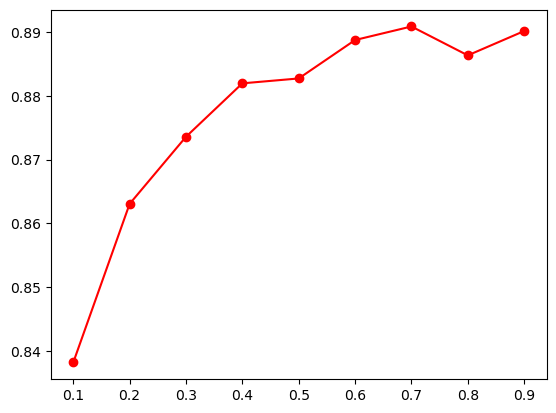

In [29]:
plt.plot(frac_value, f1_result, 'ro-')
print(f'Лучшее значение метрики: {max(f1_result)}')
print(f'Для n равном: {frac_value[f1_result.index(max(f1_result))]}')

In [30]:
%%time

frac_value = []
f1_result = []
for frac in range(68, 80, 2):
    features_downsampled, target_downsampled = downsample(train_features, train_target, frac/100)
    best_model.fit(features_downsampled, target_downsampled)
    pred = best_model.predict(test_features)
    frac_value.append(frac/100)
    f1_result.append(f1_score(pred, test_target))

Wall time: 5min 36s


Лучшее значение метрики: 0.8902840059790733
Для n равном: 0.74


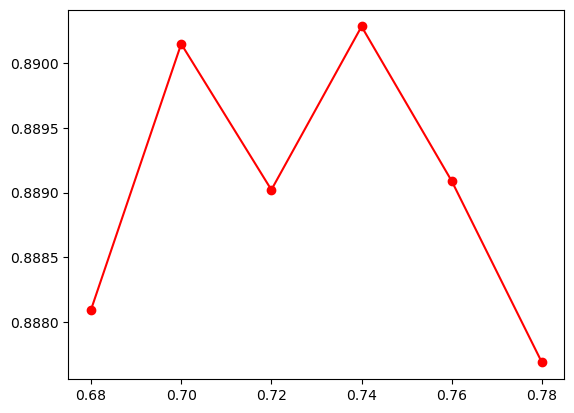

In [31]:
plt.plot(frac_value, f1_result, 'ro-')
print(f'Лучшее значение метрики: {max(f1_result)}')
print(f'Для n равном: {frac_value[f1_result.index(max(f1_result))]}')

Метод downsampling дает небольшой прирост по целевой метрике при уменьшении преобладающего класса на 30%. В связи с чем, лучшим результатом можно считать значение метрики F1 равным **0.89**.

Построим матрицу спутанности для данного случая.

In [32]:
def conf_matrix(predict, target=test_target):
    # Выведем матрицу спутанности аналогично предыдущему пункту
    cm = confusion_matrix(target, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    return plt.show()

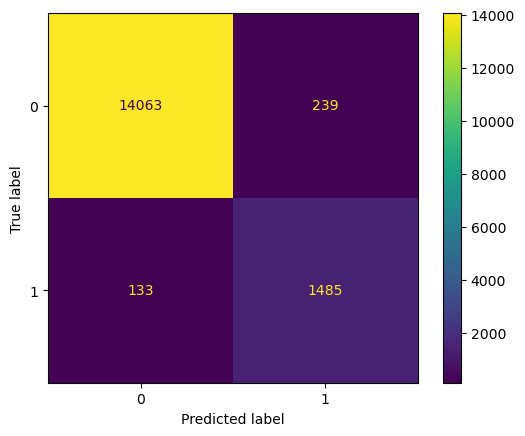

In [33]:
features_downsampled, target_downsampled = downsample(train_features, train_target, 0.7)
best_model.fit(features_downsampled, target_downsampled)
prediction = best_model.predict(test_features)    
probabilities = best_model.predict_proba(test_features)[:,1] 

conf_matrix(prediction)

По матрице спутанности можно сделать вывод, что модель хорошо предсказывает отрицательный и положительный классы. По положительному классу модель ошибается менее чем в 10% случаях. Данный результат получен на модели, обученной на токсичных текстах.

Чтобы визуализировать точность и полноту для определенной модели, мы можем создать кривую точность-полнота.Эта кривая показывает компромисс между точностью и полнотой для различных пороговых значений.

In [34]:
def pr_curve(probabilities, target=test_target):
    precision, recall, thresholds = precision_recall_curve(target, probabilities)
    fpr, tpr, thresholds = roc_curve(target, probabilities)
    # Построение Precision-Recall Curve
    plt.figure(figsize=(9,9))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})')
    # Закрашивание области под кривой
    plt.fill_between(recall, precision, alpha=0.2)  
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # Добавление пунктирной линии для разделения области
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.ylim(0.45, 1.1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.grid(True)
    plt.show()

In [35]:
def plot_pr_curve(target_valid, probabilities_valid):
   
    precisions, recalls, thresholds = precision_recall_curve(target_valid, probabilities_valid)
    fscores = np.divide((2 * precisions * recalls)
                        , (precisions + recalls)
                        , where=(precisions + recalls)!=0)
    optimal_idx = np.argmax(fscores)

    plt.figure(figsize=(6, 6))
    plt.step(recalls, precisions, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.vlines(recalls[optimal_idx], ymin=0, ymax=1.05, linestyles='--', color='orange')
    plt.hlines(precisions[optimal_idx], xmin=0, xmax=1, linestyles='--', color='orange')
    plt.title(f'PR-кривая (threshold = {thresholds[optimal_idx]:.2f}, f1 = {np.max(fscores):.3f})')
    plt.grid(True)
    plt.show()

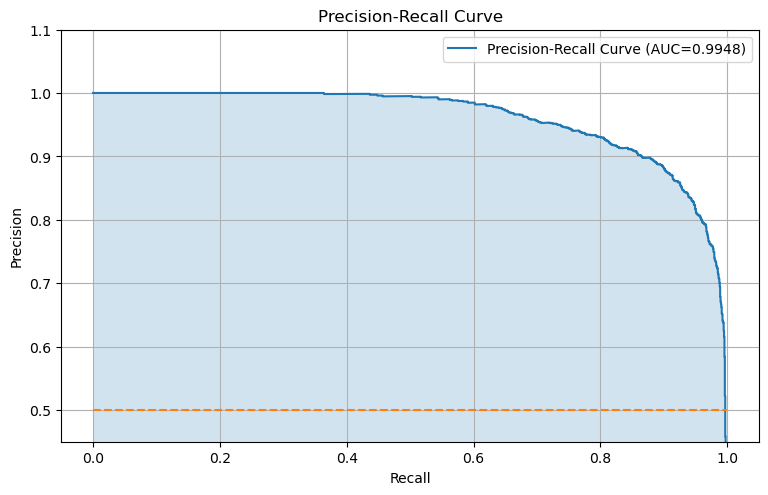

In [36]:
pr_curve(probabilities, test_target)

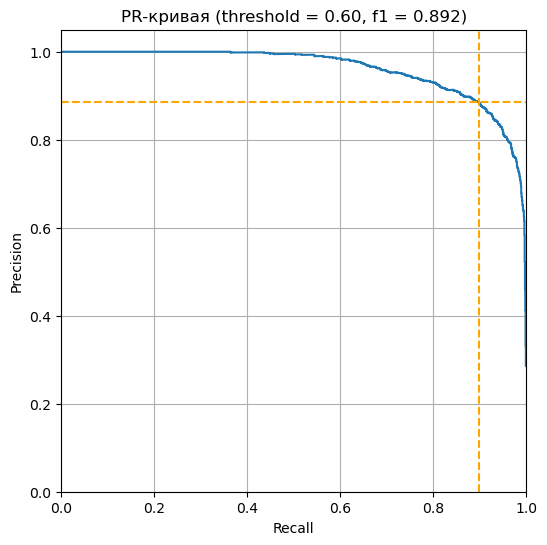

In [37]:
plot_pr_curve(test_target, probabilities)

Из графика PR-кривой видно, что оптимальный порог классификации находится на уровне 0.62 со значением f1 равным 0.892, что незначительно выше базового порога.

Построим кривую ROC-AUC.

In [38]:
def roc_auc_curve(probabilities, target=test_target):
    # Посчитаем ложноположительные и истинноположительные предсказания для построения ROC-кривой
    fpr, tpr, thresholds = roc_curve(target, probabilities)
    # Зададим график ROC-кривой
    plt.figure(figsize=(9,9))
    plt.plot(fpr, tpr, linestyle='-', label=f'ROC-AUC Curve (AUC={auc(fpr, tpr):.4f})')
    # Закрашивание области под кривой
    plt.fill_between(fpr, tpr, alpha=0.2)  
    # Построим результат предсказания случайной модели
    plt.plot([0, 1], [0, 1], linestyle='--')
    # Задаем пределы графика
    plt.xlim(0,1)
    plt.ylim(0,1)
    # Задаем названия осей
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Название графика
    plt.title('ROC-кривая модели')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.grid(True)

    return plt.show()

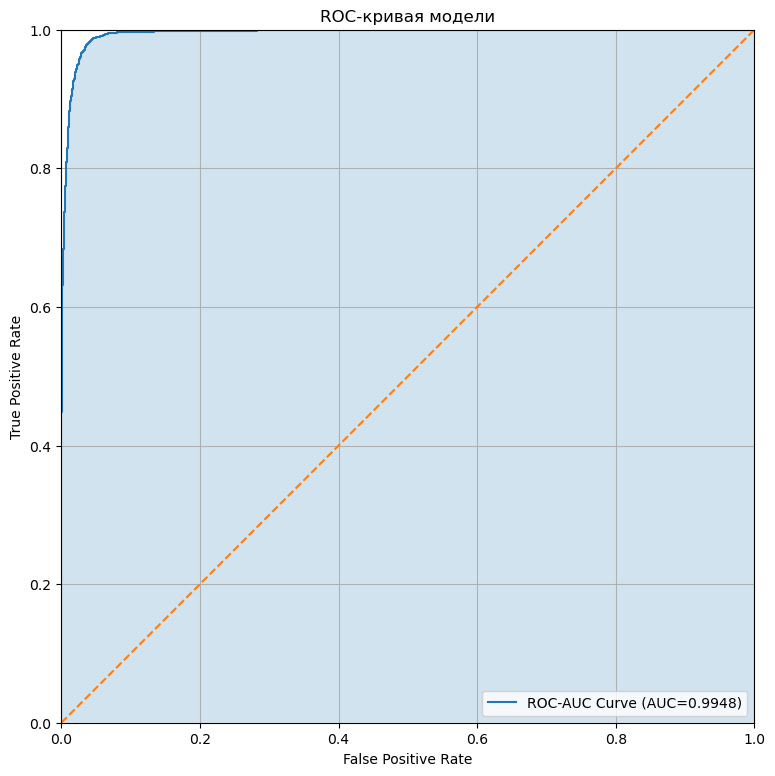

In [39]:
roc_auc_curve(probabilities, test_target)

Недостатком метрики ROC-AUC является чувствительность к дисбалансу классов. В нашем случае это прекрасно видно, модель имеет великолепный результат по метрике ROC-AUC. В связи с чем использовать ROC-AUC кривую не целесообразно. 

## Построение линейной модели

В части оценки синтементальности твитов линейные модели показывают хорошие результаты. Так как в линейных моделях отсутствуют гиперпараметры, которые можно "тюнить" Optuna, выделим для них отдельный раздел проекта.

In [40]:
from sklearn.linear_model import RidgeClassifier

In [41]:
linear_model = RidgeClassifier()                           # Создаем линейную модель
linear_model.fit(features_downsampled, target_downsampled) # Обучаем
linear_predict = linear_model.predict(test_features)       # Предсказываем
result_f1 = f1_score(test_target, linear_predict)          # Считаем f1-меру предсказаний модели
recall = recall_score(test_target, linear_predict)         # Считаем recall предсказаний модели


print(f'Метрика Recall: {recall},')
print(f'Метрика F1 модели: {result_f1},')

Метрика Recall: 0.919035846724351,
Метрика F1 модели: 0.8888224745965331,


D:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.30837e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Получаем значение по целевой метрике незначительно хуже бустинга. Данный результат подтверждает предположение о хорошей работе линейных моделей в области NLP.

### Сравнение со случайной моделью

Проверим полученную модель на адекватность. Для dummy модели необходимо выбрать стратегию.

In [42]:
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(features_downsampled, target_downsampled)
dummy_prediction = dummy_model.predict(test_features)

# Вычисляем метрику F1
f1 = f1_score(dummy_prediction, test_target)

f1

0.16807247735082786

Перебрав все возможные варианты, лучшее значение метрики получилось 0.16(7) по F1-мере. 

В связи с чем можно сделать вывод о том, что полученная модель предсказывает лучше случайной.

## Выводы

От интернет-магазина "Викишоп" получено задание по созданию инструмента для отыскания токсичных комментариев с целью их последующей модерации. Такие задачи решаются с помощью раздела NLP машинного обучения.

В качестве исходных данных получен кампус английских твитов. Кампус состоит из сырого текста, без удаления стоп слов и символов. Для выполнения задания выбрана языковая модель BERT, которая хорошо работает на сыром тексте и не требует предварительной обработки текста. Единственная необходимая обработка - модель BERT имеет ограничение в 512 символов текста. Выбрана преподготовленная модель BERT 'JungleLee/bert-toxic-comment-classification'. Преимущества модели - для токсичных текстов модель показывает результат лучше базовой модели, а так же сокращение времени подготовки embeddings в 6 раз.

Датасет разделен на тестовую и тренировочную выборку в соотношении 9:1, выявлен дисбаланс классов. Отрицательный класс представлен практически в 9 раз больше положительного. Для борьбы с дисбалансом выбраны методы upsampling и downsampling. Для подбора параметров выбрана модель машинного обучения **LGBM**, так как совмещает в себе скорость и качество предсказания, а метрикой выбора параметров выбрана целевая метрика согласно техническому задания заказчика - **F1-мера**. Для модели подобраны оптимальные гиперпараметры библиотекой Optuna.

После подбора гиперпараметров модель предсказала токсичность текста с результатом **0.890** по метрике F1. Для улучшения предсказания и борьбы с дисбалансом проведен подбор параметров upsampling/downsampling. Для метода upsampling оптимальный множитель редкого класса **n = 1**, что значит отсутсвие улучшения предсказания данным методом. Для downsampling подобрана доля от общего количества частого класса **frac = 0.7**, результат **0.891**. 

Проведена проверка моделей логистической регрессии и dummy-модели. Случайная модель предсказывает с результатом 0.16(7), что означает адекватность работы подобранной модели.

Модель линейной классификации Ridge, использующая регуляризацию по методу наименьших квадратов, показывает результат равный **0.889** по метрике F1. Данный результат указывает на то, что линейные модели хорошо подходят для решения задач NLP.